# Import

### Import dataset

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

verbose = False

# TODO: add automatic download function if data is not present
#       by integrating kaggle-api

train='data/train'
test ='data/test'
temp ='data/temp'

ds = temp
# Load training set
ctr_df = pd.read_csv(ds, sep=',', header=0)
#ctr_df.info()
print(f'Imported {ctr_df.shape[0]} rows of \'{ds}\'')
print(f'Head of imported dataset \'{ds}\'')
display(ctr_df.head())
verbose and ctr_df.info()


Imported 1000 rows of 'data/temp'
Head of imported dataset 'data/temp'


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10689185825462720736,0,14103004,1002,0,5b787406,f3ca2e42,50e219e0,ecad2386,7801e8d9,...,0,0,23438,320,50,2684,2,1327,100188,52
1,7449959474826015008,0,14102406,1005,1,e8f79e60,c4342784,f028772b,ecad2386,7801e8d9,...,1,0,4687,320,50,423,2,39,100148,32
2,13249818213624821186,0,14102205,1005,0,85f751fd,c4e18dd6,50e219e0,66f5e02e,6f7ca2ba,...,1,0,21691,320,50,2495,2,167,-1,23
3,10917253687916529693,0,14102412,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,22224,320,50,2561,0,547,-1,51
4,18284938291624068035,1,14102417,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17653,300,250,1994,2,39,-1,33


False

### Selection and sanity check

Since we're interested in `click` and `hour` only, let's strip them

In order to aggregate by hour, we convert `hour` field to datetime by casting it to `str` first

In [2]:
def cast_hour(x_df, format = '%y%m%d%H', verbose = False):
    '''
    Cast hour from int64 (by converting it to str) to datetime
    
    verbose Enables extensive logging
    format datetimeformat
    '''
    verbose and x_df.info()
    verbose and display(x_df.head())
    print('Cast `hour` from int64 to str')
    x_df = x_df.assign(hour=x_df['hour'].apply(str))
    print('Format `hour` datetime str to datetime object')
    x_df = x_df.assign(hour=pd.to_datetime(x_df['hour'], format=format))
    # cast hour string to datetime
    verbose and x_df.info()
    verbose and display(x_df.head())
    return x_df

def strip_fields(x_df, verbose = False):
    '''
    strip fields and copy it to avoid SettingWithCopyWarning
    '''
    res_df = x_df[['hour', 'click']].copy()
    verbose and display(res_df.head())
    return res_df

In [3]:
# strip fields and convert datetime fields
hc_df = (
  ctr_df.pipe(strip_fields, verbose = verbose)
        .pipe(cast_hour, verbose = verbose)
)

# check result
display(hc_df.head())
print(f'Prepared {hc_df.shape[0]} rows of \'{ds}\'')

Cast `hour` from int64 to str
Format `hour` datetime str to datetime object


,hour,click
0,2014-10-30 04:00:00,0
1,2014-10-24 06:00:00,0
2,2014-10-22 05:00:00,0
3,2014-10-24 12:00:00,0
4,2014-10-24 17:00:00,1


Prepared 1000 rows of 'data/temp'


# Aggregate

### Aggregate data by hour 

In [4]:
# group by hour and calculate mean, count
grouped_hc_df = hc_df.groupby(by=[
    hc_df.hour.map(lambda h: h.hour)
]).agg(['mean', 'count', 'sum']).reset_index()
verbose and grouped_hc_df.count()
verbose = True
df = grouped_hc_df

verbose and print(df.info())
verbose and print(df.index)
verbose and print(df.columns)
verbose and display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (hour, )        24 non-null     int64  
 1   (click, mean)   24 non-null     float64
 2   (click, count)  24 non-null     int64  
 3   (click, sum)    24 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 896.0 bytes
None
RangeIndex(start=0, stop=24, step=1)
MultiIndex([( 'hour',      ''),
            ('click',  'mean'),
            ('click', 'count'),
            ('click',   'sum')],
           )


hour     click          
            mean count sum
0    0  0.153846    26   4
1    1  0.277778    18   5
2    2  0.285714    28   8
3    3  0.210526    19   4
4    4  0.134615    52   7

# Plot

## Plotting Impressions vs. Clicks and CTR

<IPython.core.display.Javascript object>


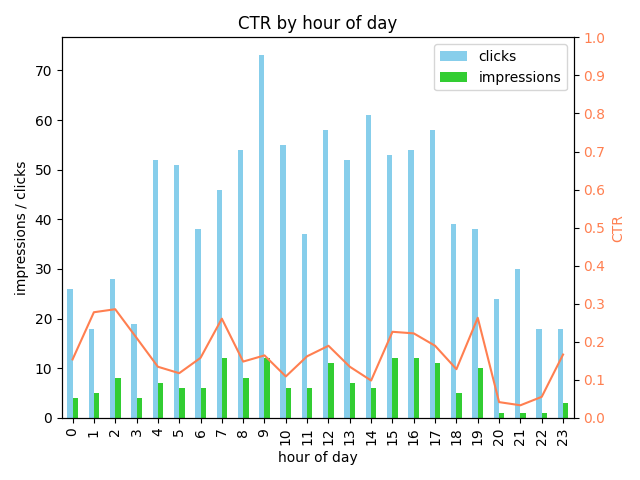

In [5]:
import numpy as np
fig, axes = plt.subplots()
axes = df.plot(
    ax=axes,
    kind='bar',
    title="CTR by hour of day",
    x=('hour',''),
    y=[('click', 'count'),('click','sum')],
    color=['skyblue', 'limegreen'],
    stacked=False,
    fill=True
)
ctr_ax = axes.twinx()  # instantiate a second axes that shares the same x-axis

axes.set_xlabel('hour of day')
axes.set_ylabel('impressions / clicks')
axes.legend(['clicks', 'impressions'])

x=df[('hour','')]
ctr = df[('click', 'mean')]

color = 'coral'
ctr_ax.set_ylim(bottom=0.0, top=1.0)
ctr_ax.set_ylabel('CTR', color=color)
ctr_ax.plot(x, ctr, color=color)
ctr_ax.yaxis.set_ticks(np.arange(0, 1.1, step=0.1))
ctr_ax.tick_params(axis='y', labelcolor=color, )

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
